In [194]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
from matplotlib.pylab import date2num
import matplotlib.pylab as pylab
import matplotlib.font_manager as font_manager
import matplotlib.dates as mpl_dates
import bokeh
from bokeh.plotting import output_notebook, output_file, reset_output
from bokeh.plotting import figure, show, save
from bokeh.layouts import layout, gridplot, column, row
from bokeh.models import MultiLine, Legend, CategoricalColorMapper, LinearInterpolator, Scatter, Range1d, Toggle, BoxAnnotation, CustomJS, ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid, Title, LabelSet, Label, HoverTool, WheelZoomTool, BoxZoomTool, PanTool
from bokeh.models.glyphs import Line, Text
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6, Viridis256, Category20, Paired
from bokeh.models import Span
import seaborn as sns

# from bokeh.io import curdoc, show
# output_notebook()

In [807]:
etfs_excel=pd.read_csv('path\ETFs_excel_categories.csv')
ticklist=etfs_excel.Ticker.values.tolist()
print(len(ticklist))

In [968]:
def get_price_hist(ticker):
    today = datetime.today().strftime("%d/%m/%Y")
    today = datetime.strptime(today + " +0000", "%d/%m/%Y %z")
    to = int(today.timestamp())
    # Get date ten years ago as UTC timestamp
    yr_ago = today-relativedelta(years=15)
    fro = int(yr_ago.timestamp())
    # Put stock price data in dataframe
    url = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={fro}&period2={to}&interval=1d&events=history".format(ticker=ticker, fro=fro, to=to)
    data = pd.read_csv(url)
    # Convert date to timestamp and make index
    data.index = data["Date"].apply(lambda x: pd.Timestamp(x))
    data.drop("Date", axis=1, inplace=True)

    return data

df_tickers={}
empty_tickers=[]
for ticker in ticklist:
    try:
        df_tickers.update({ticker:get_price_hist(ticker)})
        delay=np.random.uniform(5,10)
        time.sleep(delay)
    except Exception as e:
        empty_tickers.append(ticker)
        print(ticker, 'did not return,', e)
        pass

print('Finished query with',len(df_tickers.keys()),'indices returned and ', len(empty_tickers), 'lost')

In [1677]:
period=5
freq='BM'
td=datetime.today().strftime('%Y-%m-%d')
yr_ago = (datetime.strptime(td + " +0000", "%Y-%m-%d %z")-relativedelta(years=period)).strftime('%Y-%m-%d')
df=pd.DataFrame()
df = df.reindex(pd.date_range(start=yr_ago,end=td,freq=freq))

for key in df_tickers.keys():
    adj = df_tickers[key]['Adj Close']
    adj = adj.reindex(pd.date_range(start=yr_ago,end=td,freq=freq))
    adj=pd.DataFrame(adj)
    adj.columns=[key]
    df=df.merge(adj, how="outer", right_index=True, left_index=True)

In [3]:
df_annualized=df.dropna(axis=1, how='all').apply(lambda x:(x/x[x.first_valid_index()])**(365/(x.index-x.first_valid_index()).days)-1, axis=0) #for each ticker finds the first date and calculates the timedelta for each point, then annualizes each of the return at particular timestamp
sort=df_annualized.T.sort_values(df_annualized.index[-1], ascending=False).T
sort=sort*100 #convert to percentage

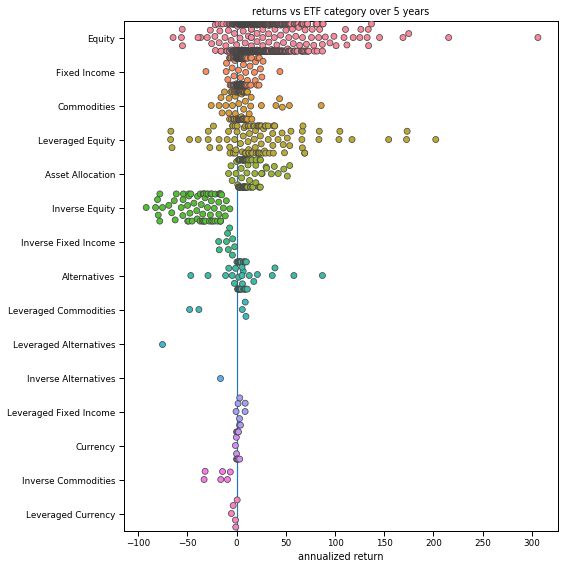

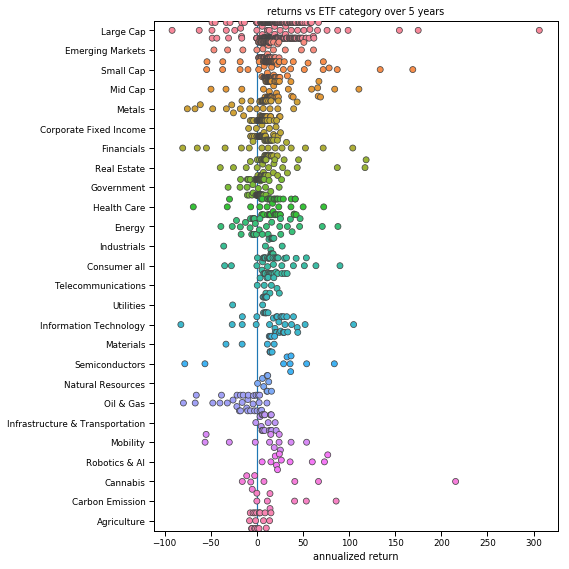

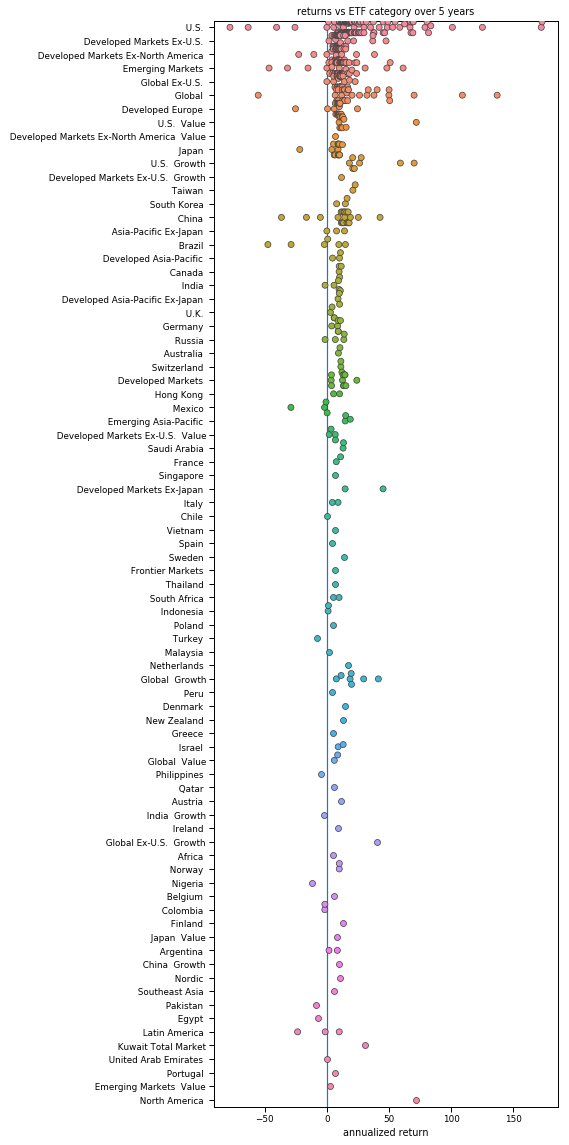

In [1684]:
def plot_swarmplot(df, category, ysize, period):
    time_unit='years'
    df=pd.DataFrame(df.T.iloc[-1]).reset_index()
    df.columns=['Ticker', 'category', 'industry', 'total_market', 'return']
    fig, ax = plt.subplots()
    fig.set_size_inches(8, ysize)
    ax = sns.swarmplot(x="return", y=category, data=df, color=None,size=6, edgecolor='gray',linewidth=0.75)
    ax.axvline()
    ax.set_title('returns vs ETF category over {} {}'.format(period, time_unit))
    ax.set(xlabel='annualized return', ylabel='')

    plt.tight_layout()
    plt.savefig(r'C:\Users\Vladimir.Roznyatovsk\Desktop\movie\{}_swarmplot_{} {}.jpg'.format(category, period, time_unit), dpi=600)
    plt.show()
    
test=etfs_excel.set_index(['Ticker', 'category', 'industry', 'total_market']).merge(sort.T, left_on='Ticker', right_index=True, how='left')#.drop(['ETF_description'], axis=1)#.groupby('h1')
ysize=8
for item in ['category', 'industry', 'total_market']:
    if item == 'total_market':
        ysize=16
    plot_swarmplot(test, item, ysize, period)

In [1026]:
def plot_lines_multi(df, category, lw=2,pw=1400,ph=800,t_str="hover,save,pan,box_zoom,reset,wheel_zoom",t_loc='right'):

    p = figure(x_axis_type="datetime",plot_width=pw, plot_height=ph,toolbar_location=t_loc, tools=t_str)
    p.yaxis.axis_label = 'annualized return'
    p.xaxis.axis_label = 'time'

    p_dict = dict()
    colors=Category20[len(set(df.index.get_level_values(category)))]
    df_grouped=df.groupby(category)
    for name, group in df_grouped:
        group=group.droplevel(group.index.names[1:]).T
        group=group.T.sort_values(group.index[-1], ascending=False).T
        group=group.iloc[:, :10]
        source = ColumnDataSource(group)
        col_names = source.column_names
        color=colors[list(set(df.index.get_level_values(category))).index(name)]
        for col, col_name in zip(group.columns, col_names):
            p_dict[col_name] = p.line('index', col, source=source, color=color,line_width=lw, legend=name)
            p.add_tools(HoverTool(
                renderers=[p_dict[col_name]],
                tooltips=[('datetime','@index{%Y-%m-%d %H:%M:%S}'),(col, f'@{col}'),(name,f'@{name}')],
                formatters={'index': 'datetime'}
            ))
            hover = p.select(dict(type=HoverTool))
            hover.mode = 'mouse'

    p.legend.location = "top_left"
    output_file(r'path\name.html'.format(category))
    save(p)
        
    show(p)
    

test=etfs_excel.set_index(['Ticker', 'category']).merge(norm.T, left_on='Ticker', right_index=True, how='left')
plot_lines_multi(test._get_numeric_data(), 'category')

In [4]:
# volatility  
month_ret=sort.pct_change()
etf_std=month_ret.std()
month_mean=month_ret.mean()
month_sharpe=(month_mean-0.01/12)/etf_std
outdata_df=pd.concat([month_mean, etf_std, month_sharpe], axis=1)
outdata_df.columns=['Mean','STD','Sharpe']
outdata_df=outdata_df.sort_values(by=['Sharpe'],ascending=False)

# plot bars of Sharpe
ax = outdata_df['Sharpe'].plot.bar(color=plt.cm.gist_rainbow(np.linspace(0, 1,len(outdata_df))))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  This is separate from the ipykernel package so we can avoid doing imports until


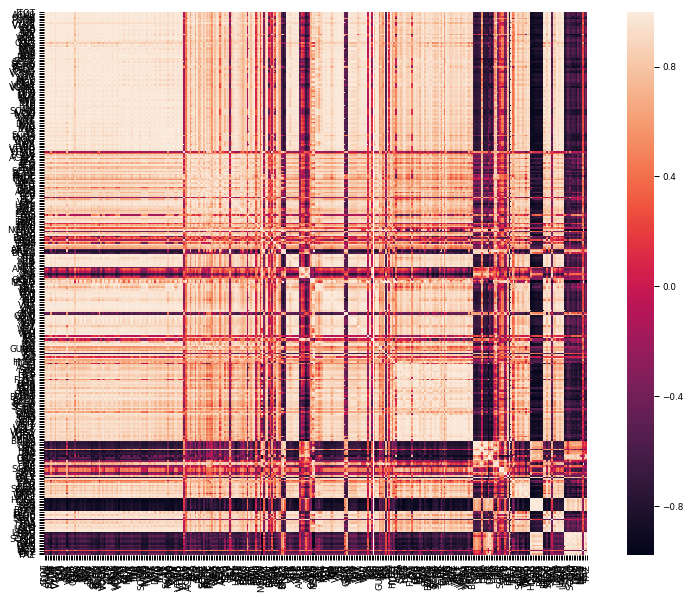

In [350]:
# Corrolation matrix
pos_sharpe=outdata_df.index[(outdata_df['Sharpe'] > 0.1) & (outdata_df['Mean'] > 0.003)].tolist()
onlypossharpe=month_ret[month_ret.columns & pos_sharpe]
# corrmat=onlypossharpe.corr()
corrmat=df.corr()

# Plotting the corr-mat as a heat map
import seaborn as sns
sns.set_context(context='paper',font_scale=1)       
plt.figure(figsize=(14, 10))                                           
sns.heatmap(corrmat,square=True,xticklabels=1,yticklabels=1)
plt.show()